# Imports

In [1]:
#IMPORTS
########
import pandas as pd
import requests

import mysql.connector
import tpclean.tpclean as tp

from sqlalchemy import create_engine

#custom imports
from Scripts.config import role, bucket_name, prefix, bucket_path, sub_path

#establish connection
from Scripts.config import host, db
from Private.private import user , password

# Load Data

## establish connection

In [2]:
#load credentials
conn_kwargs = {"host":host, 
               "user":user, 
               "password":password}
conn = tp.sql_connect(db,db_type="mysql",**conn_kwargs)
#conn = mysql.connector.Connect(database = db, **conn_kwargs)
c = conn.cursor()

#connecting via sqlalchemy because pandas needs an engine to store data in an mysql DB
engine = create_engine(f'mysql+pymysql://{user}:{password}@{conn_kwargs["host"]}:3306/{db}')

Connecting to mysql
successfully imported module
Connection to mysql successfull. with curser MySQLCursor: (Nothing executed yet)


## SQL Querries

In [3]:
tp.sql("""show tables""")

,Tables_in_debater
0,content
1,conversations
2,test


words_df = tp.sql("""SELECT origin
FROM content
GROUP BY origin
HAVING COUNT(freq) = 0""")

In [7]:
words_df = tp.sql("""SELECT origin
FROM content
GROUP BY origin""")

In [8]:
words_df

,origin
0,AM_101_affirmativeaction_pro.wav
1,DJ_1_ban-video-games_pro.wav
2,DJ_644_year-round-schooling_pro.wav
3,DJ_681_ip-rights_pro.wav
4,DJ_841_blasphemy_pro.wav
5,EH_1_ban-video-games_pro.wav


In [9]:
job_list = list(words_df.iloc[:,0])
file = job_list[4]

In [10]:
file

'DJ_841_blasphemy_pro.wav'

In [11]:
text_df = tp.sql(f"""SELECT full_text FROM conversations WHERE filename = "{file}" """)
text = text_df["full_text"][0]

In [12]:
text

"we should criminalize Blast me because it's a kidney hate speech and because it leads to public disorder and resentment between religious groups. So let's start by talking about what, exactly, we're going to criminalize, because we're not gonna criminalize every single kind of blast. So if someone is just like an atheist and they say, I don't believe in God, possibly in some kind of public setting those aren't the people that we're going to prosecute. And that's not the kind of things that were worrying about what we're talking about, our people who are outwardly insulting people who may say things like God is evil, God is hateful or people who desecrate some kind of holy objects through people who will like, for example, burn a Koran or trying to, like, burn like a like a crumb click or burn some kind of cross things like that, things that I think truly embody a kind of hatred for religion on God. Let's start by talking about why these things were necessary first because it's a kidne

# Feature Engineering

In [13]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.corpus import stopwords

In [14]:
file_df = tp.sql(f"""SELECT pos_in_conv,
                    LOWER(content) as content
                    FROM content
                    WHERE type = "pronunciation" and origin = "{file}" """)

In [15]:
tokens = np.asarray(file_df.iloc[:,1]).reshape(len(file_df),)

In [16]:
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(text) 

## Remove Stopwords and Lemmatize

In [17]:
from nltk.stem.wordnet import WordNetLemmatizer

stopword_list = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [18]:
#define function for stopping and lemmatizing
stoplem = lambda x: np.NaN if x in stopword_list else lemmatizer.lemmatize(x)
#remove stoppwords and lemmatize ramaining words
file_df["lemmatized"] = file_df["content"].apply(stoplem)

In [19]:
#create freqency dict
fDist_lemm = FreqDist(file_df["lemmatized"].dropna(),)

In [20]:
#append frequencies to lemmatized words
freqs = pd.DataFrame.from_dict(fDist_lemm,orient = "index", columns = ["freq"])
file_df = pd.merge(file_df,freqs, how = "left", left_on = "lemmatized", right_index = True)

## Vizualisation

+ Upload Freqdists to new SQL Table
+ TODO : Make Wordclouds in Tableau

In [21]:
from wordcloud import WordCloud

In [22]:
def generate_wordcloud(text, **kwargs): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          random_state = 42,
                          background_color = "white",
                          width=800,
                          height=400,
                          scale = 1,
                          max_words = 15,
                          relative_scaling = 1.0, # set or space-separated string
                          **kwargs
                          ).generate_from_frequencies(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [25]:
file_df

,pos_in_conv,content,lemmatized,freq
0,0,we,NaN,NaN
1,1,should,NaN,NaN
2,2,mass,mass,1.0
3,3,murderer,murderer,1.0
4,4,me,NaN,NaN
5,5,newton,newton,1.0
6,6,it's,NaN,NaN
7,7,caught,caught,1.0
8,8,kidney,kidney,1.0
9,9,hate,hate,3.0


In [ ]:
generate_wordcloud(fDist_lemm)

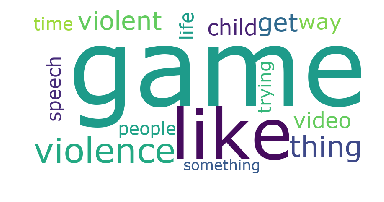

In [23]:
#lemmatized wordlcloud
generate_wordcloud(fDist_lemm)

## Bigrams

In [ ]:
file_df.head()

In [ ]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

In [ ]:
finder = BigramCollocationFinder.from_words(file_df["lemmatized"].dropna())

In [ ]:
finder.nbest(BigramAssocMeasures.likelihood_ratio, 10)

In [ ]:
bigrams_fd = finder.ngram_fd

In [ ]:
def bigram_to_single_word(bigrams_fd):
    out = dict(zip([x[0]+" "+x[1] for x in bigrams_fd.keys()],bigrams_fd.values()))
    return out

In [ ]:
testfd = bigram_to_single_word(bigrams_fd)
generate_wordcloud(testfd)

# Sentiment analysis

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
sc = lambda x: sia.polarity_scores(x)["compound"]
file_df["sentiment_score"] = file_df["lemmatized"].dropna().apply(sc)
file_df["weight"] = file_df["freq"]*file_df["sentiment_score"]

In [ ]:
file_df.head(25)

## Load Data to DB

In [ ]:
file_df.dropna().head(10)

In [ ]:
#update DB
updates = file_df.dropna()
for i in range(len(updates)):
    row = updates.iloc[i]
    out =[f'{key} = "{row[key]}"' for key in row.keys()[1:]]
    set_ = ", ".join(out)
    querry = f"""UPDATE content
                 SET {set_}
                 WHERE pos_in_conv = {row['pos_in_conv']}
                 AND origin = "{file}"
             """
    c.execute(querry)
conn.commit()
print("Inserted frequencydict in content")

In [ ]:
file

# Summarizing the Text

To Summarize the Text an external API called Aylien is used.

In [ ]:
from aylienapiclient import textapi
from Private.private import aylien_app_id,aylien_API_KEY
from Scripts.config import cfg_summary_len ,cfg_summary_lang

In [ ]:
aylien = textapi.Client(aylien_app_id,aylien_API_KEY)

In [ ]:
summary = aylien.Summarize({"title": file, 
                  "text": text,
                 "sentences_number": cfg_summary_len, 
                 "language": cfg_summary_lang })

In [ ]:
summary_text = " ".join(summary["sentences"])

In [ ]:
c.execute(f"""UPDATE conversations
            SET summary = '{summary_text}'
            WHERE filename = '{file}'""")
conn.commit()

# Make ready for export

In [26]:
conn.close()

In [30]:
[0,1,2,3,4,5,6][1:1+5]

[1, 2, 3, 4, 5]